In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [ ]:
# Load your CSV
df = pd.read_csv('Bangalore_Traffic_Pulse.csv')

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Optional: Extract Day/Month/Is_Weekend for feature engineering
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Is_Weekend'] = df['Date'].dt.weekday >= 5  # Saturday=5, Sunday=6

In [3]:
df.head()

,Date,Area Name,Road/Intersection Name,Traffic Volume,Average Speed,Travel Time Index,Congestion Level,Road Capacity Utilization,Incident Reports,Environmental Impact,Public Transport Usage,Traffic Signal Compliance,Parking Usage,Pedestrian and Cyclist Count,Weather Conditions,Roadwork and Construction Activity,Day,Month,Is_Weekend
0,2022-01-01,Indiranagar,100 Feet Road,50590,50.230299,1.500000,100.000000,100.000000,0,151.180,70.632330,84.044600,85.403629,111,Clear,No,1,1,True
1,2022-01-01,Indiranagar,CMH Road,30825,29.377125,1.500000,100.000000,100.000000,1,111.650,41.924899,91.407038,59.983689,100,Clear,No,1,1,True
2,2022-01-01,Whitefield,Marathahalli Bridge,7399,54.474398,1.039069,28.347994,36.396525,0,64.798,44.662384,61.375541,95.466020,189,Clear,No,1,1,True
3,2022-01-01,Koramangala,Sony World Junction,60874,43.817610,1.500000,100.000000,100.000000,1,171.748,32.773123,75.547092,63.567452,111,Clear,No,1,1,True
4,2022-01-01,Koramangala,Sarjapur Road,57292,41.116763,1.500000,100.000000,100.000000,3,164.584,35.092601,64.634762,93.155171,104,Clear,No,1,1,True


In [4]:
cat_cols = ['Area Name', 'Road/Intersection Name', 'Weather Conditions', 'Roadwork and Construction Activity']
le_dict = {}  # Save encoders for later

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # Save encoder


In [5]:
# Derived features
df['Speed_to_Volume'] = df['Average Speed'] / (df['Traffic Volume'] + 1)
df['Incidents_per_Capacity'] = df['Incident Reports'] / (df['Road Capacity Utilization'] + 1)

# Target
y = df['Congestion Level']

# Features for training
feature_cols = [
    'Traffic Volume', 'Average Speed', 'Road Capacity Utilization',
    'Incident Reports', 'Pedestrian and Cyclist Count',
    'Area Name', 'Road/Intersection Name', 'Weather Conditions', 'Roadwork and Construction Activity',
    'Day', 'Month', 'Is_Weekend',
    'Speed_to_Volume', 'Incidents_per_Capacity'
]

X = df[feature_cols]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [8]:
y_pred = gb_model.predict(X_test)

print("--- Gradient Boosting ---")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 3))
print("MSE:", round(mean_squared_error(y_test, y_pred), 3))
print("R2:", round(r2_score(y_test, y_pred), 3))


--- Gradient Boosting ---
MAE: 2.933
MSE: 19.38
R2: 0.964


In [9]:
joblib.dump(gb_model, 'congestion_model.pkl')
joblib.dump(le_dict, 'encoders.pkl')


['encoders.pkl']

In [ ]:
def predict_congestion(user_input, df_hist, model, encoders):
    """
    user_input: dict with keys 'Area Name', 'Road Name', 'Weather', 'Roadwork'
    df_hist: original dataset for historical averages
    """
    df_input = pd.DataFrame([user_input])

    # Encode categorical features
    for col in ['Area Name', 'Road/Intersection Name', 'Weather Conditions', 'Roadwork and Construction Activity']:
        le = encoders[col]
        df_input[col] = le.transform(df_input[col])

    # Fill numerical features using historical averages for that Area/Road
    row_mask = (df_hist['Area Name'] == df_input['Area Name'].iloc[0]) & \
               (df_hist['Road/Intersection Name'] == df_input['Road/Intersection Name'].iloc[0])

    for num_col in ['Traffic Volume', 'Average Speed', 'Road Capacity Utilization', 'Incident Reports', 'Pedestrian and Cyclist Count']:
        df_input[num_col] = df_hist.loc[row_mask, num_col].mean()
        if np.isnan(df_input[num_col].iloc[0]):  # fallback if no matching row
            df_input[num_col] = df_hist[num_col].mean()

    # Derived features
    df_input['Speed_to_Volume'] = df_input['Average Speed'] / (df_input['Traffic Volume'] + 1)
    df_input['Incidents_per_Capacity'] = df_input['Incident Reports'] / (df_input['Road Capacity Utilization'] + 1)

    df_input['Day'] = 1
    df_input['Month'] = 1
    df_input['Is_Weekend'] = False

    # Feature order
    feature_cols_order = [
        'Traffic Volume', 'Average Speed', 'Road Capacity Utilization',
        'Incident Reports', 'Pedestrian and Cyclist Count',
        'Area Name', 'Road/Intersection Name', 'Weather Conditions', 'Roadwork and Construction Activity',
        'Day', 'Month', 'Is_Weekend',
        'Speed_to_Volume', 'Incidents_per_Capacity'
    ]

    pred = model.predict(df_input[feature_cols_order])
    return pred[0]


In [18]:
user_input = {
    'Area Name': 'Indiranagar',
    'Road/Intersection Name': '100 Feet Road',
    'Weather Conditions': 'Clear',
    'Roadwork and Construction Activity': 'No'
}

congestion_score = predict_congestion(user_input, df, gb_model, le_dict)
print("Predicted Congestion Level:", round(congestion_score, 2))


Predicted Congestion Level: 97.9


In [12]:
# Predict on X_test
y_pred = gb_model.predict(X_test)


In [13]:
# Create a DataFrame for easy comparison
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Show first 10 rows
comparison.head(10)


,Actual,Predicted
554,100.000000,100.276952
6304,100.000000,100.009058
1330,79.106799,79.807434
6884,73.844329,76.848724
4801,59.958537,56.743055
6752,87.494419,87.749995
8524,56.527237,51.815301
6253,84.363226,89.403452
7371,78.961834,88.629551
8473,100.000000,100.043683


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R2 Score: {r2:.3f}")


MAE: 2.933
MSE: 19.380
R2 Score: 0.964


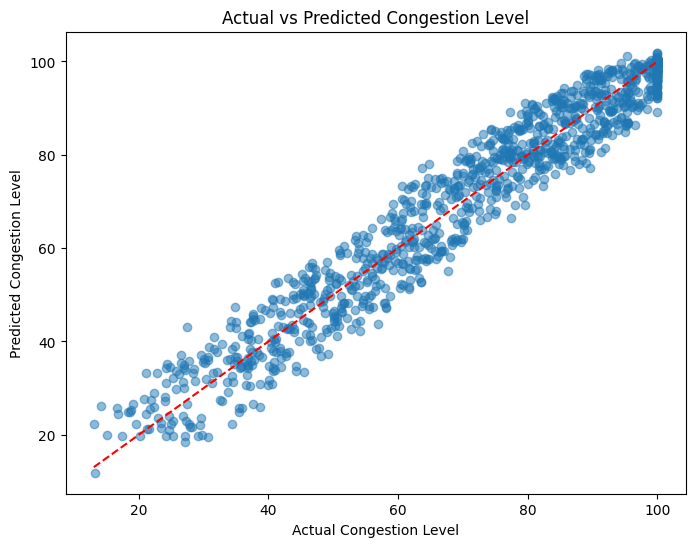

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Congestion Level")
plt.ylabel("Predicted Congestion Level")
plt.title("Actual vs Predicted Congestion Level")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.show()


In [ ]:
example_input = {
  "Area Name": "Indiranagar",
  "Road/Intersection Name": "100 Feet Road",
  "Weather Conditions": "Rain",
  "Roadwork and Construction Activity": "Yes",
};

predicted_congestion = predict_congestion(example_input, df, gb_model, le_dict);
print("Example Predicted Congestion Level:", round(predicted_congestion, 2));

Example Predicted Congestion Level: 97.98


In [ ]:
import joblib

# Save the Gradient Boosting model
joblib.dump(gb_model, 'congestion_model.pkl')

# Save the dictionary of LabelEncoders
joblib.dump(le_dict, 'label_encoders.pkl')

print("Model and encoders saved successfully!")


Model and encoders saved successfully!
